<a href="https://colab.research.google.com/github/duyvm/funny_stuff_with_llm/blob/main/learning-rag/Demo_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain[openai] langchain-core beautifulsoup4 langchain-pinecone gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.3/524.3 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45

Demo agenda:

- Part 1: QA system with vector database

  - Part 1-1: Basic QA RAG

  - Part 1-2: Improvement techniques

- Part 2: QA system with SQL data

  - Part 2-1: using predefined workflow

  - Part 2-2: using simple agent

# Import libraries and helper functions

In [91]:
import bs4
import os
import gradio as gr

from langchain import hub
from langchain.chat_models import init_chat_model

from langchain_community.document_loaders import WebBaseLoader

from langchain_openai import OpenAIEmbeddings

from langchain_core.documents import Document
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.vectorstores import InMemoryVectorStore

from langchain_pinecone import PineconeVectorStore

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.checkpoint.memory import MemorySaver

from typing_extensions import List, TypedDict
from IPython.display import Image, display

from google.colab import userdata
from pinecone import Pinecone, ServerlessSpec

def start_ui(graph, config, share=False, debug=True):
    """
    Start the Gradio UI for the ChatBot
    """

    # streaming response method
    async def stream_fn(user_input, history):

        state = {
            "question": user_input,
        }

        bot_reply = ""

        async for chunk, metadata in graph.astream(
            state,
            config,
            stream_mode="messages",
        ):
            if isinstance(chunk, AIMessage):  # Filter to just model responses
                if chunk.content.strip() in ["NA", ""]:
                    continue
                bot_reply += chunk.content
                yield bot_reply

    # Start the interface (it will print a link you can click)
    chat_ui = gr.ChatInterface(
        fn=stream_fn,
        title="🤖 Demo RAG",
        type="messages",
    )

    chat_ui.launch(share=share, debug=debug)

def load_data(urls, vector_store):
    """
    Parse data from webpage and insert into vector store
    """
    # load new url, splint and index it
    web_loader = WebBaseLoader(
            web_paths=urls,
            bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("mw-content-ltr mw-parser-output", "mw-page-title-main")
            )
        )
    )

    documents = web_loader.load()

    # split the documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_documents(documents)

    # Pinecorn API has limit message size of 4MB
    # Batch insert the chunks into the vector store
    batch_size = 100
    for i in range(0, len(all_splits), batch_size):
        splits_batch = all_splits[i:i + batch_size]
        vector_store.add_documents(splits_batch)

### Load api keys into environment

In [3]:
PROJECT_NAME = "demo-rag"

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = f"{PROJECT_NAME}"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Part 1: QA system with vector database

## Part 1-1: Basic QA RAG

- Knowledge base: a vector db (`pinecone`) for storing documents

- Llm model: `gpt-4o-mini` of `openai`

- User interacts with chatbot

- Basic functionalities:

  1. Understand user's question

  2. Search for answer from knowledge base

  3. Answer user's question

### Initialize model

In [4]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

### Create vector db

In [5]:
# In memory db
# vector_store = InMemoryVectorStore(embeddings)
pc = Pinecone(api_key=userdata.get('PINECORN_API_KEY'))

# Create Index on pinecorn for text-embedding-3-large
index_name = PROJECT_NAME

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

### Load documents

In [6]:
# load data from urls
urls = [
    "https://ja.wikipedia.org/wiki/%E3%81%93%E3%81%AE%E7%B4%A0%E6%99%B4%E3%82%89%E3%81%97%E3%81%84%E4%B8%96%E7%95%8C%E3%81%AB%E7%A5%9D%E7%A6%8F%E3%82%92!",
    "https://en.wikipedia.org/wiki/Alice_in_Chains",
    "https://en.wikipedia.org/wiki/Alanis_Morissette"
]

load_data(urls, vector_store)

### Build graph

In [19]:
# define state of langgraph
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# 1st step: retrieve documents in vector db
def retrieve(state: State) -> dict:
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

# 2nd step: generate response to user's question based on retrieved context
def generate(state: State):
    """
    Generate the response based on context
    """
    doc_content = "\n\n".join([doc.page_content for doc in state["context"]])
    # prompt_with_context = rag_prompt.invoke(input={"context": doc_content, "question": state["question"]})
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, just say that you "
        "don't know, don't try to make up an answer. Use three sentences "
        "maximum and keep the answer concise. "
        "\n\n"
        f"{doc_content}"
    )
    prompt_with_context = [SystemMessage(content=system_message)] + [HumanMessage(content=state["question"])]
    answer = llm.invoke(prompt_with_context)
    return {"answer": answer.content}

# add memory
memory = MemorySaver()

# compile the graph and test
graph_builder = StateGraph(State).add_sequence([(retrieve.__name__, retrieve), (generate.__name__, generate)])
graph_builder.add_edge(START, retrieve.__name__)
graph = graph_builder.compile(checkpointer=memory)

#### Visualize the graph

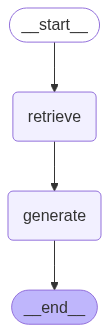

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
start_ui(graph, {"configurable": {"thread_id": "duyvm123"}}, False)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://76665698bd7e805317.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://76665698bd7e805317.gradio.live


### Testing around with chatbot

- Ask something in our documents in Japanese/English/Vietnamese

- Ask something new (`Albus Dumbledore`)

### Add more data

- Add data about Albus Dumbledore and Harry Porter

In [42]:
# load data from urls
urls = [
    "https://en.wikipedia.org/wiki/Albus_Dumbledore",
    "https://en.wikipedia.org/wiki/Harry_Potter_(character)",
]

load_data(urls, vector_store)

#### 🧠 Conclude

#### **Goods**

👍 The app can understand multi-languages

👍 The app can understand the variants of the question

#### **Need improvement**

🤔 We are considering user's question is the whole information for searching in vector db. It can lead to retrieving incorrect informations if the actual information that we want is too small consider to the length of question. How to seperate the actual relevant information piece for searching with the rest in the question.

🤔 The accuracy of answer depends a lot on retrieved informations. It can be tricky when stored information and provided information (in question) is not in the same language

#### **Some solutions**

- Query analysis

- Query re-writing

- Agentic approach

In [92]:
# define state of langgraph
class StateWithQuery(TypedDict):
    question: str
    query: str
    context: List[Document]
    answer: str
    is_query: bool

# 1st
def query_or_response(state: StateWithQuery):
    """
    Generatate query for retrieval or response directly to user
    """
    system_message = (
        "You are an assistant for query-analysis task. "
        "You receive the input from user. You analyze the input. "
        "If it is a question, you pick only relevant query key-words from that question, "
        "and remove un-needed information and DO NOT ADD any word that not from question."
        "If it is not a question, you return with 'NA'"
        "\n\n"
    )
    prompt_with_context = [SystemMessage(content=system_message)] + [HumanMessage(content=state["question"])]
    answer = llm.invoke(prompt_with_context)

    if answer.content.upper() == "NA":
        state["is_query"] = False
        state["query"] = ""
    else:
        state["is_query"] = True
        state["query"] = answer.content

    return state

# 2nd
def retrieve(state: StateWithQuery) -> dict:
    retrieved_docs = vector_store.similarity_search(state["query"])
    return {"context": retrieved_docs}

# 3rd
def generate(state: StateWithQuery):
    """
    Generate the response based on context
    """
    doc_content = "\n\n".join([doc.page_content for doc in state["context"]])
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, just say that you "
        "don't know, don't try to make up an answer. Use three sentences "
        "maximum and keep the answer concise. "
        "\n\n"
        f"{doc_content}"
    )
    prompt_with_context = [SystemMessage(content=system_message)] + [HumanMessage(content=state["query"])]
    answer = llm.invoke(prompt_with_context)
    return {"answer": answer.content}

def i_don_know(state: StateWithQuery):
    """
    Return I don't know if the answer is not available
    """
    return {"messages": [AIMessage(content="I don't know about that. Please ask another question.")]}

def is_query(state: StateWithQuery):
    if state["is_query"]:
        return retrieve.__name__
    else:
        return i_don_know.__name__

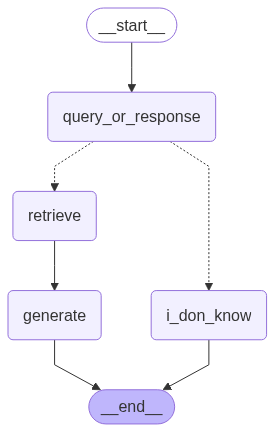

In [93]:
memory2 = MemorySaver()

graph_builder = StateGraph(StateWithQuery)

# Add each node
graph_builder.add_node(query_or_response.__name__, query_or_response)
graph_builder.add_node(retrieve.__name__, retrieve)
graph_builder.add_node(generate.__name__, generate)
graph_builder.add_node(i_don_know.__name__, i_don_know)

# Start from query_or_response
graph_builder.add_edge(START, query_or_response.__name__)

# Conditional edge after query_or_response
graph_builder.add_conditional_edges(
    query_or_response.__name__,
    is_query,
    {
        retrieve.__name__: retrieve.__name__,
        i_don_know.__name__: i_don_know.__name__,
    },
)

# Continue only if retrieve ran
graph_builder.add_edge(retrieve.__name__, generate.__name__)
graph_builder.add_edge(generate.__name__, END)
graph_builder.add_edge(i_don_know.__name__, END)

improved_graph = graph_builder.compile(checkpointer=memory2)

display(Image(improved_graph.get_graph().draw_mermaid_png()))

In [ ]:
start_ui(improved_graph, {"configurable": {"thread_id": "duyvm456"}}, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>